In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
#PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
#act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'

act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

current_version = 0 #June 23nd, 2023
current_version = 1 # July 21st 2023

stdfont = 14
stdyfrac = 0.06


In [2]:
second_rev_animals = ['AE_238','AE_239','AE_240']
animals = np.concatenate((ephys_animals,second_rev_animals))
animals = second_rev_animals

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

there are 398 trials in AE_239 day 39
there are 116 trials in AE_239 day 20
PC is 0.7758620689655172 and DP is 1.59902324595228
there are 116 trials in AE_239 day 20
PC is 0.7758620689655172 and DP is 1.59902324595228
there are 398 trials in AE_239 day 39


C:\Users\4thgr\Documents\TothSidleck2024\Notebooks\Figure 3\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)


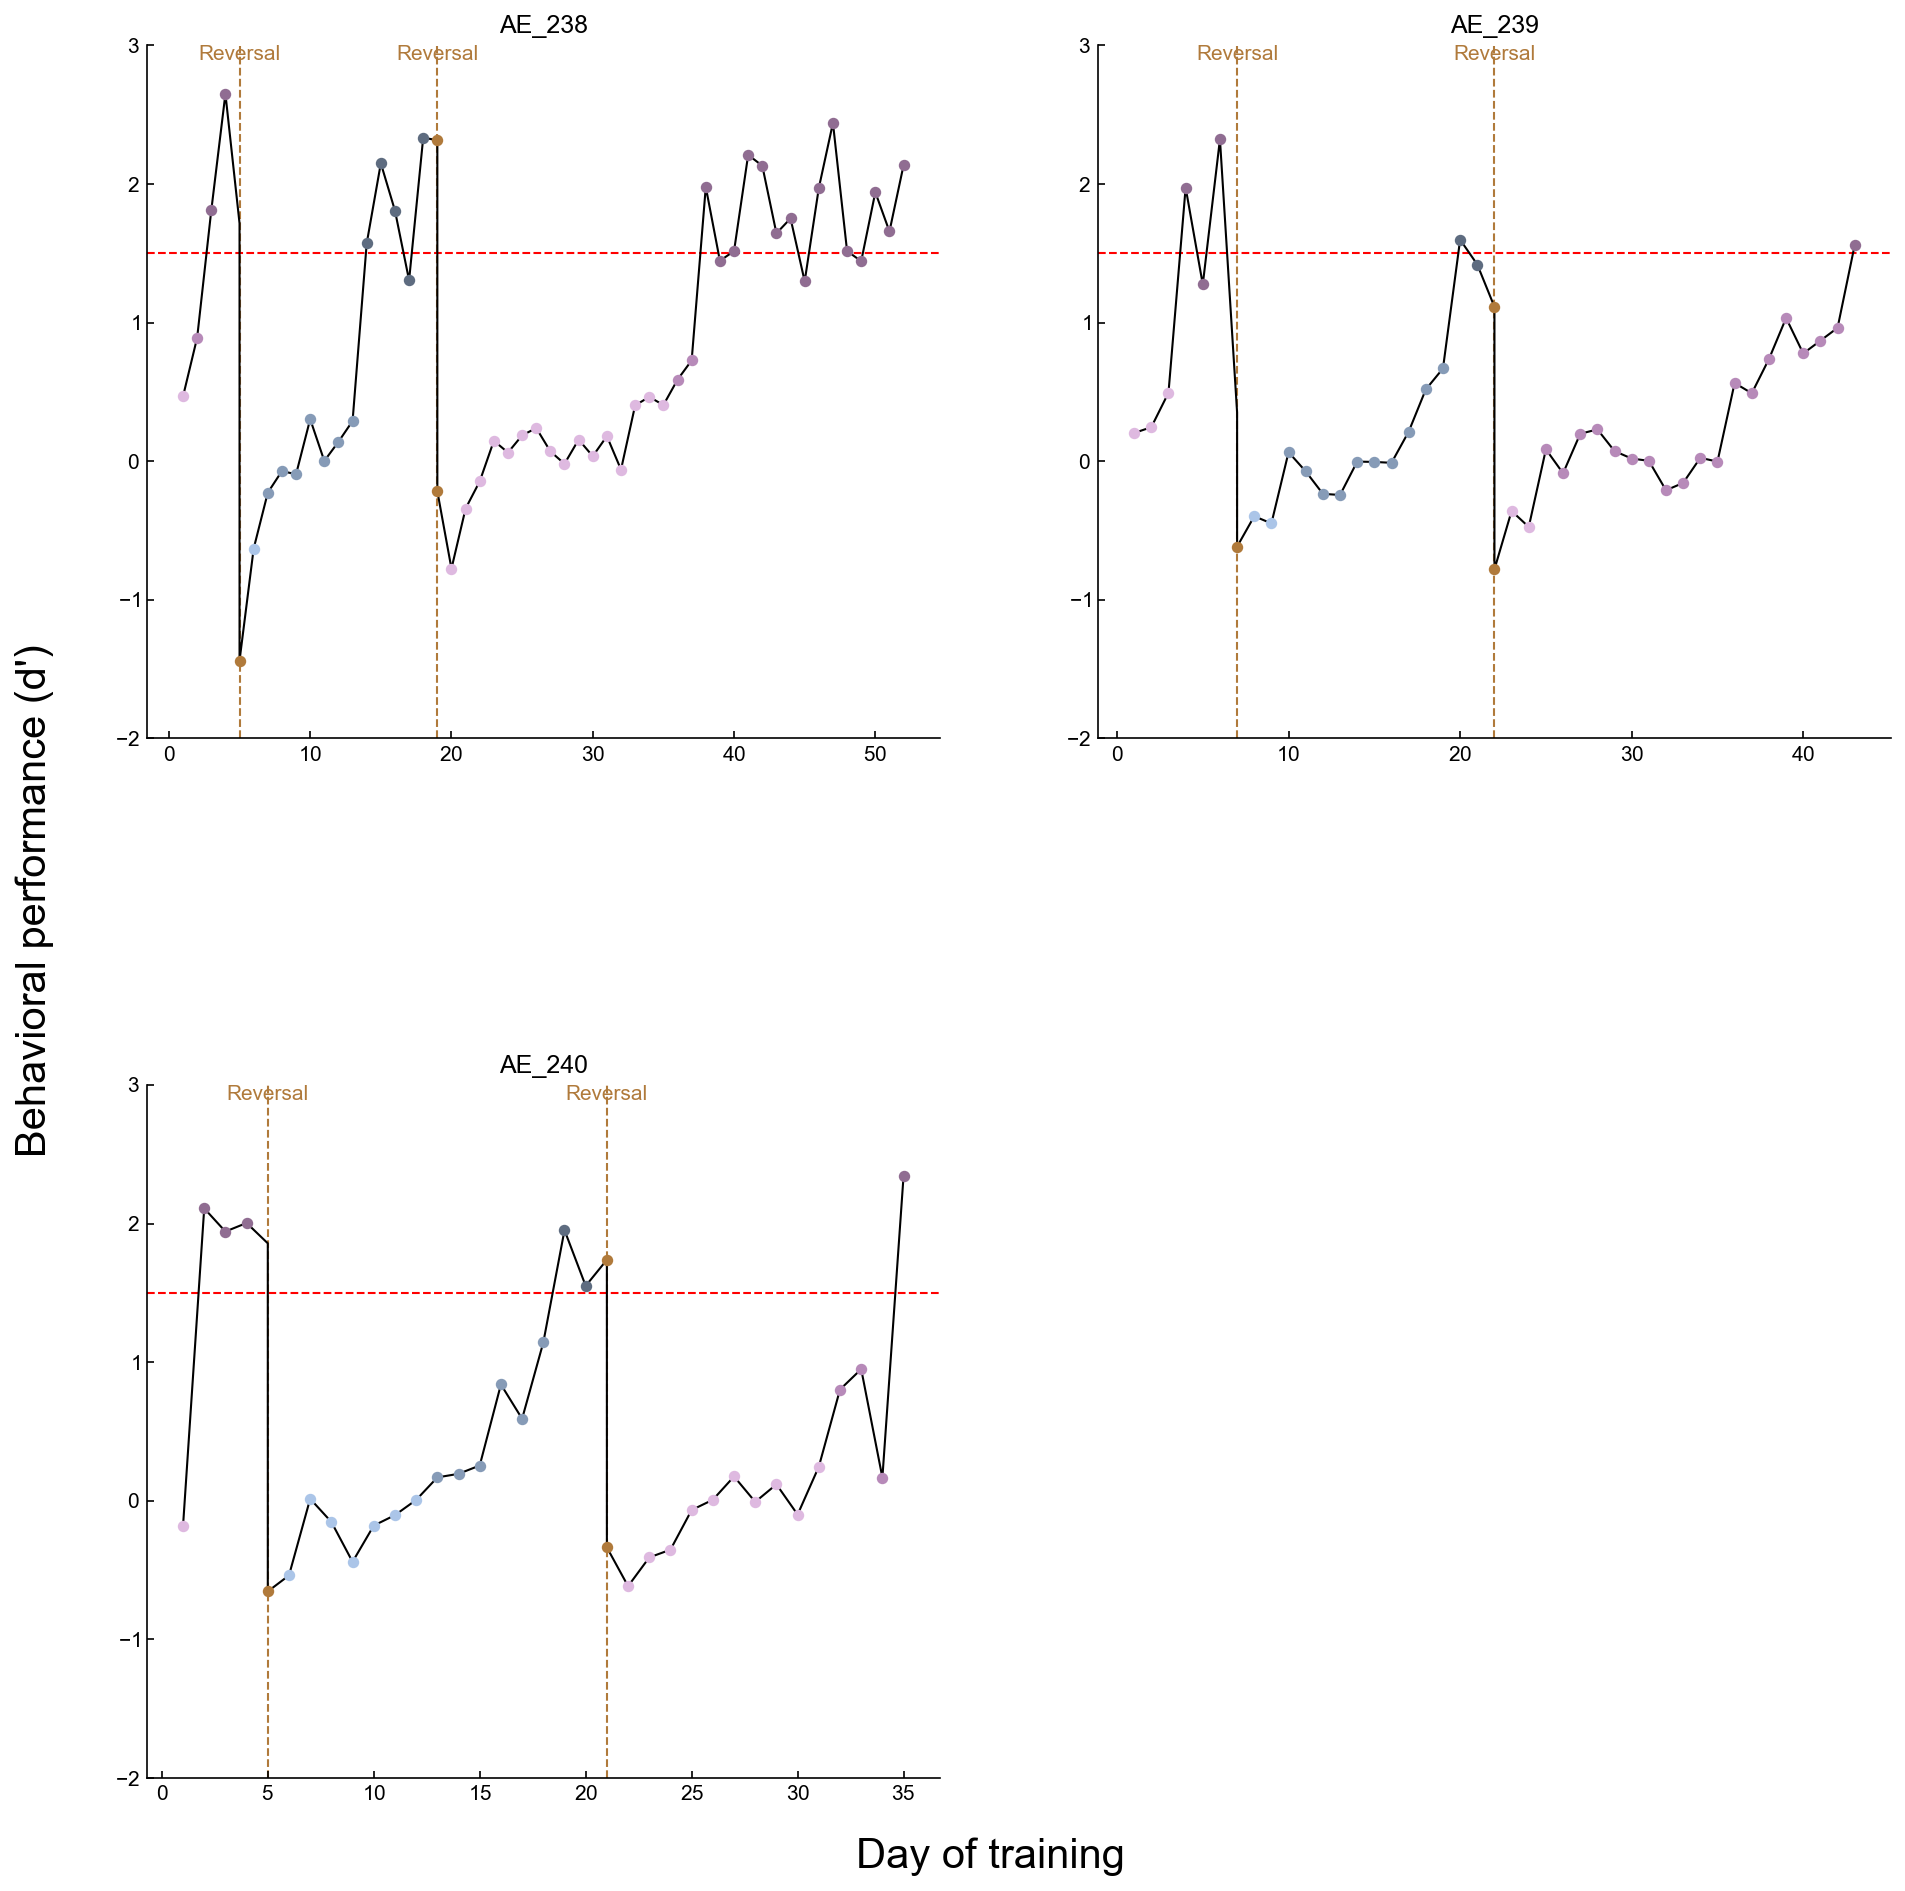

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [5]:
print('loaded')

loaded


# D' Over Learning

In [13]:
animals_list = []
learning_phases_list = []
avg_dp_list = []

for animal in tqdm(animals):
    
    this_pre_early_dps = []
    this_pre_late_dps = []
    this_pre_expert_dps = []
    this_post_early_dps = []
    this_post_late_dps = []
    this_post_expert_dps = []
    this_second_early_dps = []
    this_second_late_dps = []
    this_second_expert_dps = []
    
    reversal = np.nan
    second_reversal = np.nan

    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    if hasattr(animalBehaviors[animal],'reversal') and np.isfinite(animalBehaviors[animal].reversal):
        reversal = animalBehaviors[animal].reversal
        days.append(reversal)
    if hasattr(animalBehaviors[animal],'second_reversal') and np.isfinite(animalBehaviors[animal].second_reversal):
        second_reversal = animalBehaviors[animal].second_reversal
        days.append(second_reversal)
    days = np.sort(days)
    #Needs days
    expert_days = np.concatenate(( learning_phases[animal].pre_expert_days,learning_phases[animal].post_expert_days,learning_phases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
    
    for day_idx,day in enumerate(days):
        if day in learning_phases[animal].pre_early_days:
            this_pre_early_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].pre_late_days:
            this_pre_late_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].pre_expert_days:
            this_pre_expert_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].post_early_days:
            this_post_early_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].post_late_days:
            this_post_late_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].post_expert_days:
            this_post_expert_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].second_early_days:
            this_second_early_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].second_late_days:
            this_second_late_dps.append(dp_list[day_idx])
        if day in learning_phases[animal].second_expert_days:
            this_second_expert_dps.append(dp_list[day_idx])
            
    print(this_pre_early_dps)
            
    # print(f"animal {animal} has pre_late dp of {np.nanmean(this_pre_late_dps)}")
    # print(f"animal {animal} has pre_late min dp of {np.min(this_pre_late_dps)}")
    # print(f"animal {animal} has pre_late max dp of {np.max(this_pre_late_dps)}")
    #print(this_pre_late_dps)
    
    pre_early_dp = np.mean(this_pre_early_dps)
    pre_late_dp = np.mean(this_pre_late_dps)
    pre_expert_dp = np.mean(this_pre_expert_dps)
    post_early_dp = np.mean(this_post_early_dps)
    post_late_dp = np.mean(this_post_late_dps)
    post_expert_dp = np.mean(this_post_expert_dps)
    second_early_dp = np.mean(this_second_early_dps)
    second_late_dp = np.mean(this_second_late_dps)
    second_expert_dp = np.mean(this_second_expert_dps)
    
    
    
    
    
    
    animals_list.append(animal)
    learning_phases_list.append('pre early')
    avg_dp_list.append(pre_early_dp)
    
    animals_list.append(animal)
    learning_phases_list.append('pre late')
    avg_dp_list.append(pre_late_dp)
    
    animals_list.append(animal)
    learning_phases_list.append('pre expert')
    avg_dp_list.append(pre_expert_dp)
    
    animals_list.append(animal)
    learning_phases_list.append('post early')
    avg_dp_list.append(post_early_dp)
    
    animals_list.append(animal)
    learning_phases_list.append('post late')
    avg_dp_list.append(post_late_dp)
    
    animals_list.append(animal)
    learning_phases_list.append('post expert')
    avg_dp_list.append(post_expert_dp)

    animals_list.append(animal)
    learning_phases_list.append('second early')
    avg_dp_list.append(second_early_dp)

    animals_list.append(animal)
    learning_phases_list.append('second late')
    avg_dp_list.append(second_late_dp)

    animals_list.append(animal)
    learning_phases_list.append('second expert')
    avg_dp_list.append(second_expert_dp)
    
# print(animals_list)
# print(learning_phases_list)
# print(avg_dp_list)

# print(len(animals_list))
# print(len(learning_phases_list))
# print(len(avg_dp_list))

 67%|██████▋   | 2/3 [00:00<00:00,  3.91it/s]

[0.46811920534518625]
there are 116 trials in AE_239 day 20
PC is 0.7758620689655172 and DP is 1.59902324595228
there are 398 trials in AE_239 day 39
[0.20428015743991823, 0.24625626879846585, 0.4945108611900425]


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

[-0.18175009038958656]


In [17]:
df_dict = dict()
df_dict['animal'] = animals_list
df_dict['learning phase'] = learning_phases_list
df_dict['average d\''] = avg_dp_list
df = pd.DataFrame(df_dict)

In [18]:
df

,animal,learning phase,average d'
0,AE_238,pre early,0.468119
1,AE_238,pre late,0.892127
2,AE_238,pre expert,2.230869
3,AE_238,post early,-0.629734
4,AE_238,post late,0.049636
5,AE_238,post expert,1.834561
6,AE_238,second early,0.063781
7,AE_238,second late,0.658535
8,AE_238,second expert,1.806101
9,AE_239,pre early,0.315016


In [26]:
df.to_csv('..\\..\\Source Data Files\Fig 3i.csv')

In [21]:
pre_early_dps = []
pre_late_dps = []
pre_expert_dps = []
post_early_dps = []
post_late_dps = []
post_expert_dps = []
second_early_dps = []
second_late_dps = []
second_expert_dps = []

for row in df.iloc:
    if row['learning phase'] == 'pre early':
        pre_early_dps.append(row['average d\''])
    if row['learning phase'] == 'pre late':
        pre_late_dps.append(row['average d\''])
    if row['learning phase'] == 'pre expert':
        pre_expert_dps.append(row['average d\''])
        
    if row['learning phase'] == 'post early':
        post_early_dps.append(row['average d\''])
    if row['learning phase'] == 'post late':
        post_late_dps.append(row['average d\''])
    if row['learning phase'] == 'post expert':
        post_expert_dps.append(row['average d\''])

    if row['learning phase'] == 'second early':
        second_early_dps.append(row['average d\''])
    if row['learning phase'] == 'second late':
        second_late_dps.append(row['average d\''])
    if row['learning phase'] == 'second expert':
        second_expert_dps.append(row['average d\''])

C:\Users\4thgr\anaconda3\envs\InsanallyLabEnv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\4thgr\anaconda3\envs\InsanallyLabEnv\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


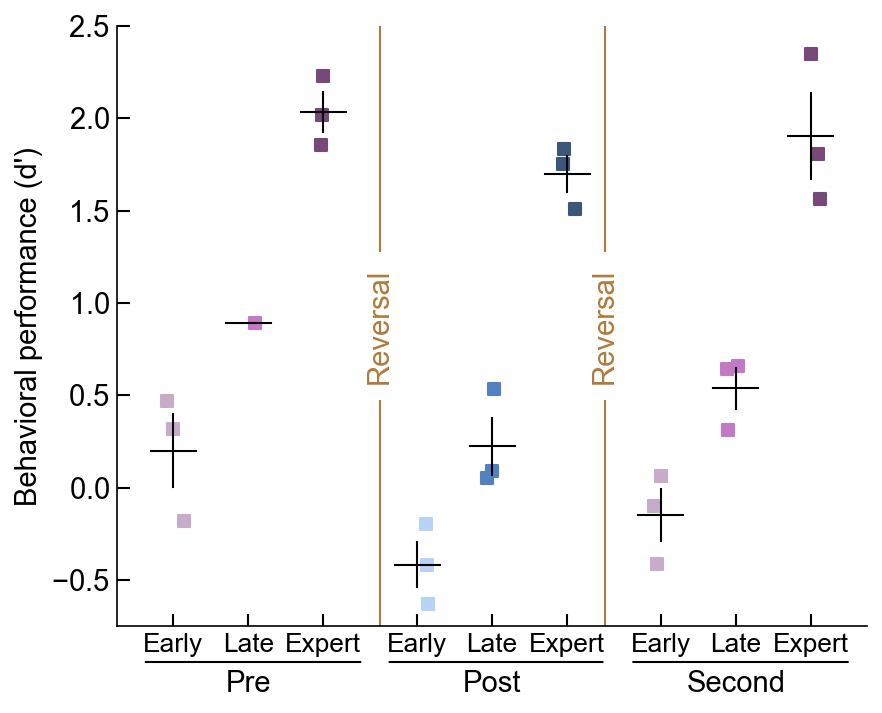

In [31]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(5, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps,second_early_dps,second_late_dps,second_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    elif idx >5:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx-6],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    else:
        ax.scatter(X+0*switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+0*switch_offset-width,idx+0*switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+0*switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.75,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,8.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+0*switch_offset,4+0*switch_offset,5+0*switch_offset,6+switch_offset,7+switch_offset,8+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
xtick_pos_second = ax.get_xticks()[7]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
t3 = ax.text(xtick_pos_second, Yval, 'Second', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0325, -stdyfrac), xycoords='axes fraction', xytext=(0.33, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.3575, -stdyfrac), xycoords='axes fraction', xytext=(0.653, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.6825, -stdyfrac), xycoords='axes fraction', xytext=(0.98, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

### Second Bar
Y = np.mean(ax.get_ylim())
t = ax.text(5.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([5.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([5.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2,t3]
# fig.savefig(os.path.join('D:\\Figures\Manuscript Figures\Second reversal dp.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [32]:
print(f"pre early: {np.nanmean(pre_early_dps)} +/- {np.std(ilep.rmnan(pre_early_dps))}")
print(f"pre late: {np.nanmean(pre_late_dps)} +/- {np.std(ilep.rmnan(pre_late_dps))}")
print(f"pre expert: {np.nanmean(pre_expert_dps)} +/- {np.std(ilep.rmnan(pre_expert_dps))}")
print(f"post early: {np.nanmean(post_early_dps)} +/- {np.std(ilep.rmnan(post_early_dps))}")
print(f"post late: {np.nanmean(post_late_dps)} +/- {np.std(ilep.rmnan(post_late_dps))}")
print(f"post expert: {np.nanmean(post_expert_dps)} +/- {np.std(ilep.rmnan(post_expert_dps))}")
print(f"second early: {np.nanmean(second_early_dps)} +/- {np.std(ilep.rmnan(second_early_dps))}")
print(f"second late: {np.nanmean(second_late_dps)} +/- {np.std(ilep.rmnan(second_late_dps))}")
print(f"second expert: {np.nanmean(second_expert_dps)} +/- {np.std(ilep.rmnan(second_expert_dps))}")

pre early: 0.2004616258105806 +/- 0.2773980450004368
pre late: 0.8921270393443941 +/- 0.0
pre expert: 2.035956052162359 +/- 0.15270582356277135
post early: -0.41696906926471183 +/- 0.17589793137885956
post late: 0.2238354689199784 +/- 0.21844858942282058
post expert: 1.6985800512969433 +/- 0.1379544568361422
second early: -0.15087656604321845 +/- 0.1991200958343533
second late: 0.5369984514369884 +/- 0.15904298042810974
second expert: 1.9045899717906902 +/- 0.3282205451417711


In [39]:
# Not all animals have every phase for pre and post. For this reason it's best to run an unpaired parametric test since
# We want to use all of the data

A1 = ilep.rmnan(pre_early_dps)
B1 = ilep.rmnan(pre_late_dps)
C1 = ilep.rmnan(pre_expert_dps)

A2 = ilep.rmnan(post_early_dps)
B2 = ilep.rmnan(post_late_dps)
C2 = ilep.rmnan(post_expert_dps)

A3 = ilep.rmnan(second_early_dps)
B3 = ilep.rmnan(second_late_dps)
C3 = ilep.rmnan(second_expert_dps)

print(len(A1))
print(len(B1))
print(len(C1))
print(len(A2))
print(len(B2))
print(len(C2))
print(len(A3))
print(len(B3))
print(len(C3))

ps = []

X,Y = (A1,B1)
ps.append(ttest_ind(X,Y).pvalue)
X,Y = (B1,C1)
ps.append(ttest_ind(X,Y).pvalue)

X,Y = (A2,B2)
ps.append(ttest_ind(X,Y).pvalue)
X,Y = (B2,C2)
ps.append(ttest_ind(X,Y).pvalue)

X,Y = (A3,B3)
ps.append(ttest_ind(X,Y).pvalue)
X,Y = (B3,C3)
ps.append(ttest_ind(X,Y).pvalue)

_,ps = pg.multicomp(ps,method='fdr_bh')
print(ps)

3
1
3
3
3
3
3
3
3
[       nan        nan 0.03193914 0.00511715 0.02509568 0.01215112]


C:\Users\4thgr\AppData\Local\Temp\ipykernel_16108\1475905811.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ps.append(ttest_ind(X,Y).pvalue)
C:\Users\4thgr\anaconda3\envs\InsanallyLabEnv\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\4thgr\anaconda3\envs\InsanallyLabEnv\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\4thgr\AppData\Local\Temp\ipykernel_16108\1475905811.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ps.append(ttest_ind(X,Y).pvalue)
